# **Singapore Attraction Image Classifier**

**Project Description:**        
> We often see beautiful images of tourist attractions on our social media but sometimes the location of these places are unknown. In this project, I hope to demonstrate the use of CNN to identify the locations of these tourist attractions. As a Proof-of-Concept, I will be using Tranfer Learning of EfficientNet model to classify images of 4 iconic tourist attractions in Singapore:
*   Gardens by the Bay
*   Changi Jewel
*   Marina Bay Sands
*   Merlion

**Contributers:** Lim Yu Bin

**Last Updated On:** 05 Feb 2023






In [1]:
# Import Libraries 

# For Machine Learning
import tensorflow as tf

# For Plotting Graphs
import matplotlib.pyplot as plt

# For Image Display
from IPython.display import Image

# For Math Operations
import numpy as np

# For Filepath Operations
import os

#### GPU Status

In [2]:
!nvidia-smi

Mon Feb 13 16:51:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Download Dataset

In [4]:
# Clear Local Directory
!rm -rf attractions

# Store image data from Dropbox into Local Directory "/content"
!wget -qq https://www.dropbox.com/s/t14oksnry9059eg/attractions.zip
!unzip -qq attractions.zip
!rm attractions.zip
!rm -r __MACOSX

# Check attractions image folder is added to /content
!ls

rm: cannot remove '__MACOSX': No such file or directory
attractions  sample_data


## Creating Dataframe - Train & Validation Sets

In [5]:
# Setting Batch Size (Batch Size for Training) & Image Size (Input Images will be scaled to Image Size)
### Batch Size: Starting with 1 as training data is small
### Image Size: Input Image Resolution for EfficientNetB7 model
BATCH_SIZE = 1
IMG_SIZE = 600

# Extracting Images of the 4 different Classes from filepath directory into a tf.data.Dataset
filepath = "./attractions"
dataset = tf.keras.utils.image_dataset_from_directory(filepath,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=(IMG_SIZE, IMG_SIZE),
                                                      label_mode='int')

NUM_CLASSES = len(dataset.class_names)

Found 320 files belonging to 4 classes.


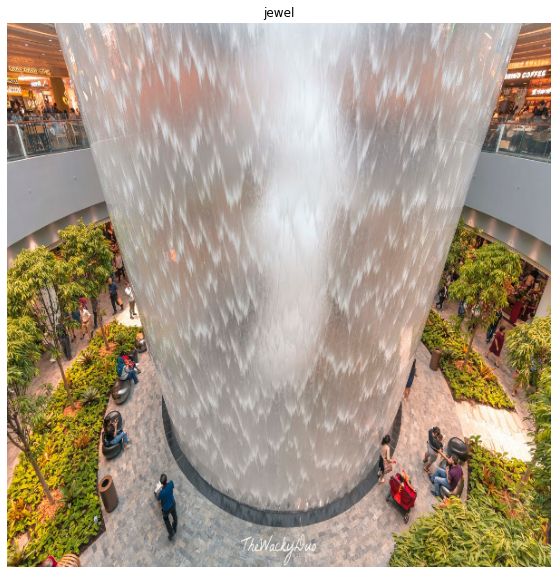

In [6]:
# Sample Image & Class in dataset
class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.title(class_names[labels[0]])
  plt.axis("off")

In [7]:
# Train, Validation, Test Split of Dataset

### Returns the number of batches in dataset
dataset_num_batches = tf.data.experimental.cardinality(dataset)

### Split dataset to Train (90%) & Validation (10%) Dataset
val_data = dataset.take(dataset_num_batches // 10)
train_data = dataset.skip(dataset_num_batches // 10)

### Split val_data to Validation & Test (4 Images) Dataset
test_data = val_data.take(4)
val_data = val_data.skip(4)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_data))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))

Number of train batches: 288
Number of validation batches: 28
Number of test batches: 4


In [8]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
validation_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Augmenting the Image data due to small Dataset
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness([-0.3,0.3]),
], name = 'data_augmentation')

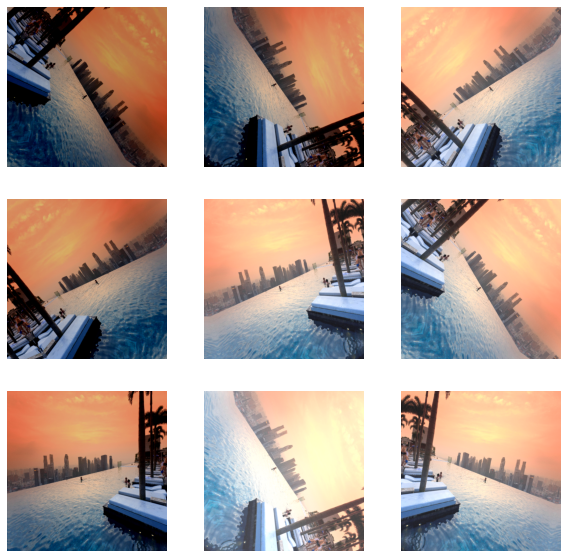

In [10]:
# Example of Augmented Images
for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, axis = 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Transfer Learning with EfficientNetB7 Model

In [11]:
# Import EfficientNetB7 Model
### include_top = False: Remove the top Dense layer in orignal EfficientNetB7 Model
### Note: Original Dense layer turns 1280 features on the penultimate layer into prediction of the 1000 ImageNet classes
base_model = tf.keras.applications.efficientnet.EfficientNetB7(input_shape = (600, 600, 3), include_top = False, weights = 'imagenet')
base_model.trainable = False

258076736/258076736 [==============================] - 12s 0us/step


In [12]:
# Creating Model 
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) #Input Layer
x = data_augmentation(inputs) #Data Augmentation Layer
x = base_model(x, training=False) #EfficientNetB7 Model Layer
x = tf.keras.layers.GlobalAveragePooling2D()(x) #Convert to 2D Vector using Average Pooling
x = tf.keras.layers.Dropout(0.1)(x) #Dropout for regularisation
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x) #Dense Layer with Output Nodes for each Class
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy', #Classes are Integers instead of One-Hot Encoded, thus using sparse_categorical_crossentropy instead of categorical_crossentropy
              metrics=['sparse_categorical_accuracy'])

In [13]:
# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600, 600, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 600, 600, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, 19, 19, 2560)     64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 4)                 10244 

In [14]:
# Check trainable layers in Model
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_2  Trainable = True
data_augmentation  Trainable = True
efficientnetb7  Trainable = False
global_average_pooling2d  Trainable = True
dropout  Trainable = True
dense  Trainable = True


In [15]:
# Configuring number of epochs to run
initial_epochs = 50

# Configuring early_stopping to stop model training after val_sparse_categorical_accuracy has not improved in 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=5,verbose=0,mode='max')

# Save the Model in training using Model Checkpoint
frozen_model_filepath = './model/frozen_model'
frozen_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = frozen_model_filepath, 
                                                      save_weights_only=True, 
                                                      monitor='val_sparse_categorical_accuracy', 
                                                      mode='max', verbose=1, 
                                                      save_best_only = True)

In [16]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[early_stopping,frozen_model_checkpoint])

Epoch 1/50


288/288 [==============================] - ETA: 0s - loss: 1.1463 - sparse_categorical_accuracy: 0.6215
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.71429, saving model to ./model/frozen_model
288/288 [==============================] - 73s 141ms/step - loss: 1.1463 - sparse_categorical_accuracy: 0.6215 - val_loss: 0.9518 - val_sparse_categorical_accuracy: 0.7143
Epoch 2/50
288/288 [==============================] - ETA: 0s - loss: 0.7474 - sparse_categorical_accuracy: 0.8854
Epoch 2: val_sparse_categorical_accuracy improved from 0.71429 to 0.78571, saving model to ./model/frozen_model
288/288 [==============================] - 39s 132ms/step - loss: 0.7474 - sparse_categorical_accuracy: 0.8854 - val_loss: 0.7648 - val_sparse_categorical_accuracy: 0.7857
Epoch 3/50
288/288 [==============================] - ETA: 0s - loss: 0.5823 - sparse_categorical_accuracy: 0.8854
Epoch 3: val_sparse_categorical_accuracy improved from 0.78571 to 0.85714, saving model to ./model/fr

Text(0.5, 1.0, 'Training and Validation Accuracy')

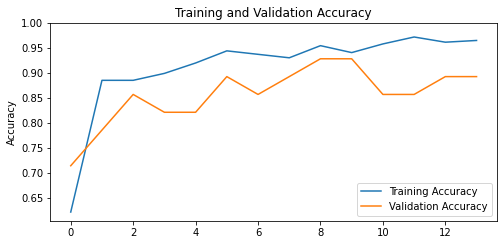

In [17]:
# Plotting Training / Validation Accuracy over Epochs with Model History
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

In [18]:
# Load the best model trained previously
model.load_weights(frozen_model_filepath)

# Fine Tuning of Model to Attraction Image Classification Task by making the top 20 layers of the base_model (EfficientNet) trainable
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

# Unfreeze top 20 layers (excluding BatchNorm layers) in EfficientNet model
unfreeze_model(base_model)

# Check trainable layers in Unfrozen Base Model
# for layer in base_model.layers:
#     print(layer.name,' Trainable =',layer.trainable)

In [19]:
# Compile the model again with unfrozen base_model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                                                           loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Additional Training to Fine Tune Unfreeze model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

# Save the Model in training using Model Checkpoint
unfrozen_model_filepath = './model/best_model'
unfrozen_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = unfrozen_model_filepath, 
                                                      save_weights_only=True, 
                                                      monitor='val_sparse_categorical_accuracy', 
                                                      mode='max', verbose=1, 
                                                      save_best_only = True)

history_fine_tune = model.fit(train_data,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=val_data,
                              callbacks=[early_stopping, unfrozen_model_checkpoint])

Epoch 14/60


288/288 [==============================] - ETA: 0s - loss: 0.2418 - sparse_categorical_accuracy: 0.9549
Epoch 14: val_sparse_categorical_accuracy improved from -inf to 0.89286, saving model to ./model/best_model
288/288 [==============================] - 63s 142ms/step - loss: 0.2418 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.3480 - val_sparse_categorical_accuracy: 0.8929
Epoch 15/60
288/288 [==============================] - ETA: 0s - loss: 0.2072 - sparse_categorical_accuracy: 0.9479
Epoch 15: val_sparse_categorical_accuracy improved from 0.89286 to 0.92857, saving model to ./model/best_model
288/288 [==============================] - 37s 125ms/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.3246 - val_sparse_categorical_accuracy: 0.9286
Epoch 16/60
288/288 [==============================] - ETA: 0s - loss: 0.1762 - sparse_categorical_accuracy: 0.9653
Epoch 16: val_sparse_categorical_accuracy improved from 0.92857 to 0.96429, saving model to ./model/b

Text(0.5, 1.0, 'Training and Validation Accuracy with Fine Tuning')

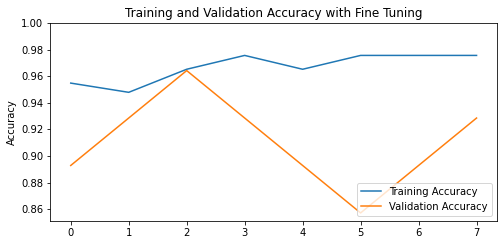

In [20]:
# Plotting Training / Validation Accuracy over Epochs with Model History
acc = history_fine_tune.history['sparse_categorical_accuracy']
val_acc = history_fine_tune.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy with Fine Tuning')

In [21]:
# Load the best model trained previously
model.load_weights(unfrozen_model_filepath)

# Store test image data from Dropbox into Local Directory "/content"
!wget -qq https://www.dropbox.com/s/fxff7yklxdzn08l/testimage.zip
!unzip -qq testimage.zip
!rm testimage.zip
!rm -r __MACOSX

rm: cannot remove '__MACOSX': No such file or directory


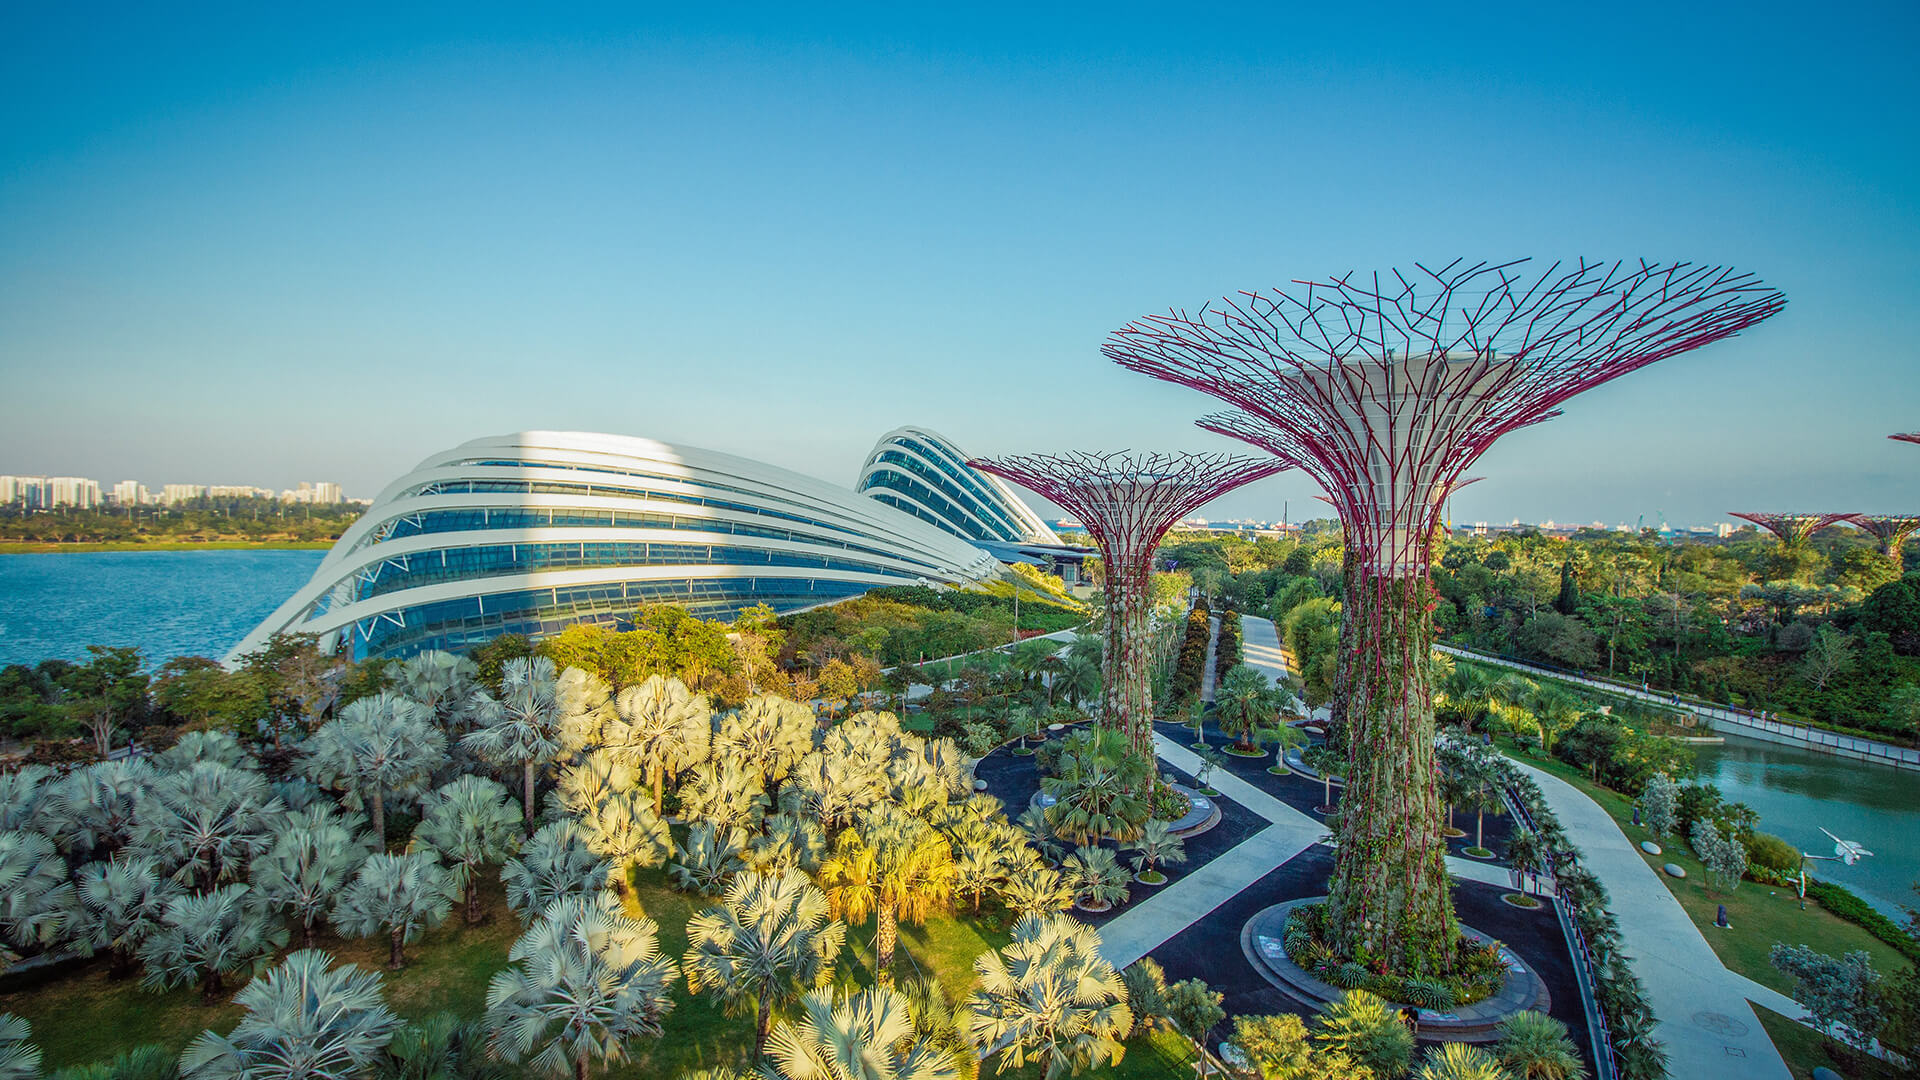

1/1 [==============================] - 5s 5s/step
Prediction Probabilities: [[0.9247479  0.02250722 0.04480754 0.00793737]]
Prediction: gardensbythebay | Confidence: 92.4747884273529 %


In [22]:
# Set Filepath for Test Image
directory = './testimage/'
image_filename = 'gardensbythebay_test.jpg'
image_path = os.path.join(directory, image_filename)
display(Image(directory+image_filename))


image = tf.keras.utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr]) 

# Prediction using Model
pred = model.predict(input_arr)
print('Prediction Probabilities:', pred)

pred_index = np.argmax(pred)
if pred_index == 0: #gardensbythebay
  print("Prediction: " + class_names[0] + " |", "Confidence:", pred[0][pred_index]*100, "%") 

elif pred_index == 1: #jewel
  print("Prediction: " + class_names[1] + " |", "Confidence:", pred[0][pred_index]*100, "%") 

elif pred_index == 2: #marinabaysands
  print("Prediction: " + class_names[2] + " |", "Confidence:", pred[0][pred_index]*100, "%")

elif pred_index == 3: #merlion
  print("Prediction: " + class_names[3] + " |", "Confidence:", pred[0][pred_index]*100, "%")

else:
  print("Error")